In [1]:
#!pip install --upgrade numpy==1.22
#!pip install --upgrade tensorflow

In [3]:
import os
import sys
import pathlib
import click
import yaml
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'


In [4]:
""" trainer.py """
import tensorflow as tf
from tensorflow.keras.utils import Progbar
import tensorflow.keras as K
from model.dataset import Dataset
from model.fp.melspec.melspectrogram import get_melspec_layer
from model.fp.specaug_chain.specaug_chain import get_specaug_chain_layer
from model.fp.nnfp import get_fingerprinter
from model.fp.NTxent_loss_single_gpu import NTxentLoss
from model.fp.online_triplet_loss import OnlineTripletLoss
from model.fp.lamb_optimizer import LAMB
from model.utils.experiment_helper import ExperimentHelper
from model.utils.mini_search_subroutines import mini_search_eval

In [ ]:
def build_fp(cfg):
    """ Build fingerprinter """
    # m_pre: log-power-Mel-spectrogram layer, S.
    m_pre = get_melspec_layer(cfg, trainable=False)

    # m_specaug: spec-augmentation layer.
    m_specaug = get_specaug_chain_layer(cfg, trainable=False)
    assert(m_specaug.bypass==False) # Detachable by setting m_specaug.bypass.

    # m_fp: fingerprinter g(f(.)).
    m_fp = get_fingerprinter(cfg, trainable=False)
    return m_pre, m_specaug, m_fp

tr_loss = K.metrics.Mean(name='train_loss')

@tf.function
def train_step(X, m_pre, m_specaug, m_fp, loss_obj, opt):
    """ Train step """
    # X: (Xa, Xp)
    # Xa: anchors or originals, s.t. [xa_0, xa_1,...]
    # Xp: augmented replicas, s.t. [xp_0, xp_1] with xp_n = rand_aug(xa_n).
    n_anchors = len(X[0])
    X = tf.concat(X, axis=0)
    feat = m_specaug(m_pre(X))  # (nA+nP, F, T, 1)
    print(f"feat: {feat}")#Debug
    m_fp.trainable = True
    with tf.GradientTape() as t:
        print(f"m_fp(feat): {m_fp(feat)}")#Debug
        emb = m_fp(feat)  # (BSZ, Dim)
        print(f"emb: {emb}")#Debug
        loss, sim_mtx, _ = loss_obj.compute_loss(emb[:n_anchors, :], emb[n_anchors:, :]) # {emb_org, emb_rep}
    g = t.gradient(loss, m_fp.trainable_variables)

    opt.apply_gradients(zip(g, m_fp.trainable_variables))
    
    avg_loss = tr_loss(loss) # To tensorboard.
    
    return avg_loss, sim_mtx # avg_loss: average within the current epoch

In [ ]:
def load_config(config_fname):
    config_filepath = './config/' + config_fname + '.yaml'
    if os.path.exists(config_filepath):
        print(f'cli: Configuration from {config_filepath}')
    else:
        sys.exit(f'cli: ERROR! Configuration file {config_filepath} is missing!!')

    with open(config_filepath, 'r') as f:
        cfg = yaml.safe_load(f)
    return cfg


def update_config(cfg, key1: str, key2: str, val):
    cfg[key1][key2] = val
    return cfg


def print_config(cfg):
    os.system("")
    print('\033[36m' + yaml.dump(cfg, indent=4, width=120, sort_keys=False) +
          '\033[0m')
    return



""" Generate fingerprint (after training) """
def generate(checkpoint_name, checkpoint_index, config, source, output, skip_dummy):
    """ Generate fingerprints from a saved checkpoint.

    ex) python run.py generate CHECKPOINT_NAME

    With custom config: \b\n
        python run.py generate CHECKPOINT_NAME -c CONFIG_NAME

    • If CHECKPOINT_INDEX is not specified, the latest checkpoint in the OUTPUT_ROOT_DIR will be loaded.
    • The default value for the fingerprinting source is [TEST_DUMMY_DB] and [TEST_QUERY_DB] specified in config file.

    """
    from model.utils.config_gpu_memory_lim import allow_gpu_memory_growth
    from model.generate import generate_fingerprint

    cfg = load_config(config)
    allow_gpu_memory_growth()
    generate_fingerprint(cfg, checkpoint_name, checkpoint_index, source, output, skip_dummy)


def evaluate(checkpoint_name, checkpoint_index, config, index_type,
             test_seq_len, test_ids, nogpu):
    """ Search and evalutation.

    ex) python run.py evaluate CHECKPOINT_NAME CHECKPOINT_INDEX

    With options: \b\n

    ex) python run.py evaluate CHECKPOINT_NAME CHEKPOINT_INDEX -i ivfpq -t 3000 --nogpu


    • Currently, the 'evaluate' command does not reference any information other
    than the output log directory from the config file.
    """
    from eval.eval_faiss import eval_faiss

    cfg = load_config(config)
    emb_dir = cfg['DIR']['OUTPUT_ROOT_DIR'] + checkpoint_name + '/' + \
        str(checkpoint_index) + '/'

    if nogpu:
        eval_faiss([emb_dir, "--index_type", index_type, "--test_seq_len",
                    test_seq_len, "--test_ids", test_ids, "--nogpu"])
    else:
        eval_faiss([emb_dir, "--index_type", index_type, "--test_seq_len",
                    test_seq_len, "--test_ids", test_ids])



In [ ]:
checkpoint_name:str = "CHECKPOINT"   # string
checkpoint_index:int = None  # int
config:str = "default"       # string 'default'
index_type:str = 'IVFPQ'  # {'L2', 'IVF', 'IVFPQ', " + "'IVFPQ-RR', 'IVFPQ-ONDISK', HNSW'}"
test_seq_len:str =  '11'   # string '1 3 5 9 11 19' segundos 
test_ids:str = "icassp"      # string 'icassp'
nogpu:bool = False         # False or True
max_epoch:int = 5     # int

In [7]:
cfg = load_config(config)
dataset = Dataset(cfg)

cli: Configuration from ./config/default.yaml


In [8]:
m_pre, m_specaug, m_fp = build_fp(cfg)

In [9]:
d = dataset.get_train_ds()

In [ ]:
d[0][1].shape

(16, 1, 8000)

In [ ]:
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display


In [ ]:
out = d[0][0][0]

In [ ]:
out

array([[0.12594604, 0.11602783, 0.1026001 , ..., 0.03756714, 0.03939819,
        0.03936768]], dtype=float32)

In [ ]:
x1 = d[0][1][0]

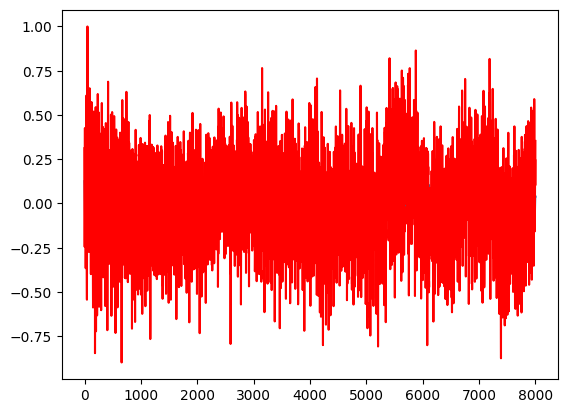

In [ ]:
plt.plot(out.squeeze())
plt.plot(x1.squeeze(),'r')
plt.show()

In [ ]:
IN = d[0]
n_anchors = len(IN[0])
n_anchors

16

In [ ]:
IN = tf.concat(IN, axis=0)

In [ ]:
IN.shape

TensorShape([32, 1, 8000])

In [ ]:
feat_IN = m_specaug(m_pre(IN))  # (nA+nP, F, T, 1)

2024-03-27 23:16:15.891969: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: sequential_1370/spec_n_cutout_21/StatefulPartitionedCall/cond/branch_executed/_104


In [ ]:
feat_IN.shape

TensorShape([32, 256, 32, 1])

In [ ]:
mel = feat_IN[0, :, :, 0].numpy()

In [ ]:
mel.shape

(256, 32)

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

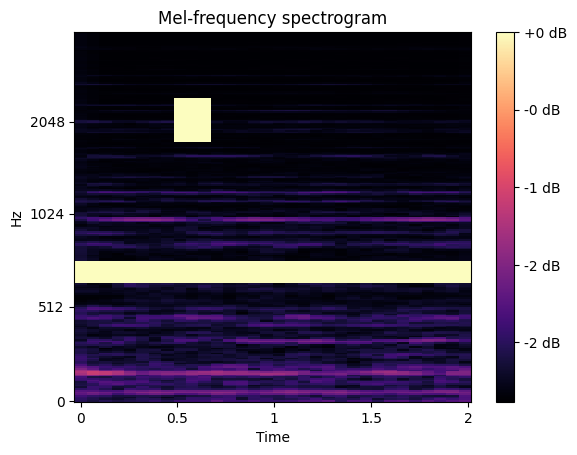

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
#S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(mel, x_axis='time',
                         y_axis='mel', sr=8000,
                         fmax=4000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [ ]:
mel2 = feat_IN[16, :, :, 0].numpy()

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

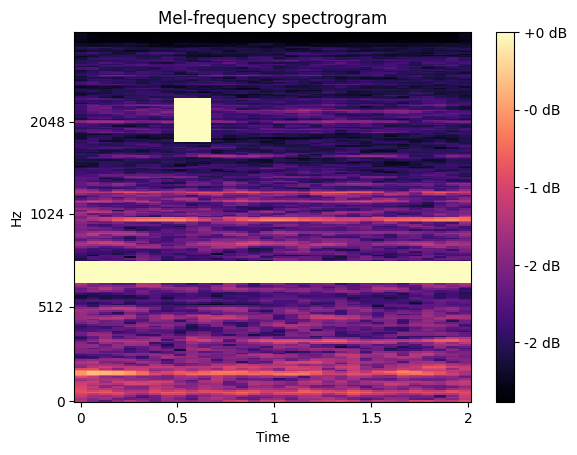

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
#S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(mel2, x_axis='time',
                         y_axis='mel', sr=8000,
                         fmax=4000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [ ]:
emb_IN = m_fp(feat_IN)

In [ ]:
# Dataloader
dataset = Dataset(cfg)

# Build models.
m_pre, m_specaug, m_fp = build_fp(cfg)

# Learning schedule
total_nsteps = cfg['TRAIN']['MAX_EPOCH'] * len(dataset.get_train_ds())
if cfg['TRAIN']['LR_SCHEDULE'].upper() == 'COS':
    lr_schedule = tf.keras.experimental.CosineDecay(
        initial_learning_rate=float(cfg['TRAIN']['LR']),
        decay_steps=total_nsteps,
        alpha=1e-06)
elif cfg['TRAIN']['LR_SCHEDULE'].upper() == 'COS-RESTART':
    lr_schedule = tf.keras.experimental.CosineDecayRestarts(
        initial_learning_rate=float(cfg['TRAIN']['LR']),
        first_decay_steps=int(total_nsteps * 0.1),
        num_periods=0.5,
        alpha=2e-06)
else:
    lr_schedule = float(cfg['TRAIN']['LR'])

# Optimizer
if cfg['TRAIN']['OPTIMIZER'].upper() == 'LAMB':
    opt = LAMB(learning_rate=lr_schedule)
elif cfg['TRAIN']['OPTIMIZER'].upper() == 'ADAM':
    opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
else:
    raise NotImplementedError(cfg['TRAIN']['OPTIMIZER'])

# Loss objects
if cfg['LOSS']['LOSS_MODE'].upper() == 'NTXENT': # Default
    loss_obj_train = NTxentLoss(
        n_org=cfg['BSZ']['TR_N_ANCHOR'],
        n_rep=cfg['BSZ']['TR_BATCH_SZ'] - cfg['BSZ']['TR_N_ANCHOR'],
        tau=cfg['LOSS']['TAU'])
else:
    raise NotImplementedError(cfg['LOSS']['LOSS_MODE'])






 aqui


\n
self.front_conv:<keras.src.engine.sequential.Sequential object at 0x7cc5b8eea550>


In [ ]:
ep = 0

# Train
""" Parallelism to speed up preprocessing.............. """
train_ds = dataset.get_train_ds(cfg['DATA_SEL']['REDUCE_ITEMS_P'])

enq = tf.keras.utils.OrderedEnqueuer(
    train_ds, use_multiprocessing=True, shuffle=train_ds.shuffle)
enq.start(workers=cfg['DEVICE']['CPU_N_WORKERS'],
            max_queue_size=cfg['DEVICE']['CPU_MAX_QUEUE'])
i = 0
while i < len(enq.sequence):
    X = next(enq.get()) # X: Tuple(Xa, Xp)
    print(f"mini-batch {i} of {len(enq.sequence)}")

    avg_loss, sim_mtx = train_step(X, m_pre, m_specaug, m_fp, loss_obj_train, opt=opt)
    print(f"avg_loss {avg_loss}")

    i += 1
enq.stop()
""" End of Parallelism................................. """

mini-batch 0 of 36365
feat: Tensor("spec_aug_chainer_11/StatefulPartitionedCall:0", shape=(32, 256, 32, 1), dtype=float32)
m_fp(feat): Tensor("finger_printer_11/StatefulPartitionedCall:0", shape=(32, 128), dtype=float32)
emb: Tensor("finger_printer_11/StatefulPartitionedCall_1:0", shape=(32, 128), dtype=float32)
feat: Tensor("spec_aug_chainer_11/StatefulPartitionedCall:0", shape=(32, 256, 32, 1), dtype=float32)
m_fp(feat): Tensor("finger_printer_11/StatefulPartitionedCall:0", shape=(32, 128), dtype=float32)
emb: Tensor("finger_printer_11/StatefulPartitionedCall_1:0", shape=(32, 128), dtype=float32)


KeyboardInterrupt: 

In [1]:
import tensorflow as tf

2024-03-28 15:28:29.305944: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-28 15:28:30.004661: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


RuntimeError: Bad StatusOr access: INTERNAL: failed initializing StreamExecutor for CUDA device ordinal 0: INTERNAL: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_OUT_OF_MEMORY: out of memory; total memory reported: 25430786048

In [ ]:
tf.test.is_built_with_cuda()

True

In [ ]:
tf.config.list_physical_devices('GPU')

2024-03-27 23:05:17.923828: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-27 23:05:17.924221: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-27 23:05:17.924531: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [ ]:
print("Versão do TensorFlow:", tf.__version__)

Versão do TensorFlow: 2.15.0


In [ ]:
import torch
print(torch.__version__)

In [ ]:
print(torch.cuda.is_available())

True


In [ ]:
if torch.cuda.is_available():
    num_devices = torch.cuda.device_count()
    print(num_devices)

    for i in range(num_devices):
        device = torch.cuda.get_device_name(i)
        print(f"Device CUDA {i}: {device}")
else:
    print("CUDA not available.")

2
Device CUDA 0: NVIDIA GeForce RTX 3090
Device CUDA 1: NVIDIA GeForce RTX 2080 Ti


In [ ]:
import tensorrt
print(tensorrt.__version__)
assert tensorrt.Builder(tensorrt.Logger())

In [ ]:
import tensorrt_lean as trt
print(trt.__version__)
assert trt.Runtime(trt.Logger())

In [ ]:
import tensorrt_dispatch as trt
print(trt.__version__)
assert trt.Runtime(trt.Logger())